In [305]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from pandas.plotting import radviz
import numpy as np
import sys

vectors_set = pd.read_table('vectors.txt',header=None, index_col=False, delimiter=r"\s+")

## Node Class Object
* The constructor gets the tree's level where the node is located.
    *  coordinate used only for inner nodes
    * ones and zeros are counting each vector's label to this node.
* For leaves:
    * classifyVector it gets the label of the vector and counts the relevant.
    * getSymbol returns the symbol of the leaf (the most common label).
    * getError returns the error which is the less voted label between the two.

In [306]:
class Node:
    
    def __init__(self, level):
        self.level = level
        self.coordinate = -1
        self.left = None
        self.right = None
        self.vectors = []
        self.leaf = False
        self.error = 0
        self.coordinates_path = []
        self.ones = 0
        self.zeros = 0
        self.symbol = -1

    def classifyVector(self, vector_label):
        if vector_label == 0:
            self.zeros += 1
        else:
            self.ones += 1
            
    def getSymbol(self):
        if self.zeros > self.ones:
            return 0
        else:
            return 1
        
    def getError(self):
        return min([self.ones,self.zeros]) 
    
    def setLeftChild(self, new_left):
        self.left = new_left
    
    def setRightChild(self, new_right):
        self.right = new_right
    
    def getCoordinate(self):
        return self.coordinate
    
    def setCoordinate(self, co):
        self.coordinate = co
        

## DecisionTree Class Object
* The constructor:
    * Gets the max level of the tree (k) and the coordinates.
    * Create a root and set the first coordinate to it.
    * Counts the number of nodes and holds the leaves while building.
    * Generate the tree by the given new root.
* generateTree class:
    * At the first step it gets the root and starts to build the tree.
    * If the node's level equals to k it means that it reached to the max level - it will be a leaf.
    * Creates left and right child and sets the coordinates for each one of them by the use of node number (only for inner nodes)
    * Goes recursivly till it reached to a leaf.
* getError gets the errors just after we are using the Algorithm class, we divide by 150 which is the number of total vectors.

In [307]:
class DecisionTree:
    def __init__(self, k):
        self.k = k
        self.root = Node(1)
        self.root.vectors = vectors_set.index
        self.coordinates = []
        self.leaves = []
        self.error = 0
        
    def generateResults(self):
        self.getNodes(self.root)
        self.error = self.root.error/150
        
    def getNodes(self, node):
        if node != None:
            if node.left == None and node.right == None:
                self.leaves.append(node)
                return
            else:
                self.coordinates.append(node.coordinate)
                self.getNodes(node.left)
                self.getNodes(node.right)
    
    def getError(self):
        return self.error

## BruteForceAlgorithm Class
* The construcor:
    * Gets the k which is the max level.
    * Creates all permutations of coordinates set size by k filling with numbers between 0-7.
    * Loads the data (vectors)
    * Keeps the best tree at the end of the algorithm
* start method:
    * Will find the tree with the minimal errors from all the given permutations
    * for each tree, which will be generated automatically in the DecisionTree constructor, it will use the runTree method which returns the error of the tree and decides if it has a lower error than all previous ones.
* runTree method:
    * for each vector (150) it traverse and fills the leaves with labels.
    * then we sum all of the errors of the leaves in the tree and return the errror.
* traverseVector method:
    * Gets vector and a node.
    * Traverse the tree by the coordinates of the vector which is given from the current node at each step.
    * Till it reach to a node and then add the vector's label to the "vote" of the leaf.

In [308]:
class BruteForceAlgorithm:
    
    def __init__(self, k, vectors):
        self.k = k
        self.vectors_set = vectors
        
    def getTree(self):
        tree = DecisionTree(self.k)
        self.run(tree.root)
        tree.generateResults()
        return tree
        
    def run(self, node):

        if node.level == self.k:
            
            for vector in node.vectors:
                node.classifyVector(self.vectors_set.iloc[vector][8])
            
            node.error = node.getError()
            node.symbol = node.getSymbol()
            return
        
        best_coordinate = -1
        min_error = sys.maxsize
        
        for coordinate in range(8):
            if coordinate not in node.coordinates_path:
                node.coordinate = coordinate

                left = Node(node.level + 1)
                right = Node(node.level + 1)

                for vector in node.vectors:
                    value = self.vectors_set.iloc[vector][coordinate]
                    if value == 0:
                        left.vectors.append(vector)
                    else:
                        right.vectors.append(vector)

                
                left.coordinates_path.extend(node.coordinates_path)
                right.coordinates_path.extend(node.coordinates_path)
                left.coordinates_path.append(coordinate)
                right.coordinates_path.append(coordinate)
                self.run(left)
                self.run(right)

                error = left.error + right.error

                if error < min_error:
                    min_error = error
                    
                    if left.error != 0:
                        node.left = left
                    if right.error != 0:
                        node.right = right
                    best_coordinate = coordinate

        node.coordinate = best_coordinate
        node.coordinates_path.append(best_coordinate)
        node.error = min_error

## BinaryEntropy Class

In [309]:
class BinaryEntropy:
    
    def __init__(self, k, vectors):
        self.k = k
        self.vectors_set = vectors
        self.best_tree = None
        self.leaves = []
        self.errors = 0
        self.root = Node(1)
        self.root.vectors = vectors.index
        self.coordinates = []
    
    def start(self):
        self.getTree(self.root)
        return self.root
    
    def getTree(self, node):
        if node != None:
            if node.level == self.k or (node != self.root and (node.ones == 0 or node.zeros == 0)):
                node.leaf = True
                self.leaves.append(node)
                node.symbol = node.getSymbol()
                return

            left_child = None
            right_child = None

            min_error = sys.maxsize
            best_coordinate = -1

            for coordinate in range(8):

                if coordinate not in node.coordinates_path:
                    temp_left = Node(node.level+1)
                    temp_right = Node(node.level+1)

                    for index in node.vectors:
                        value = self.vectors_set.iloc[index][coordinate]
                        label = self.vectors_set.iloc[index][8]
                        if value == 0:
                            temp_left.classifyVector(label)
                            temp_left.vectors.append(index)
                        else:
                            temp_right.classifyVector(label)
                            temp_right.vectors.append(index)

                    error = sys.maxsize
                    if len(temp_left.vectors) != 0 and len(temp_right.vectors) != 0:
                        error = self.getEntropyError(temp_left, temp_right)

                    if error < min_error and coordinate not in node.coordinates_path:
                        min_error = error
                        best_coordinate = coordinate
                        left_child = temp_left
                        right_child = temp_right

            if best_coordinate == -1:
                node.leaf = True
                self.leaves.append(node)
                node.symbol = node.getSymbol()
            else:
                node.setCoordinate(best_coordinate)
                node.coordinates_path.append(best_coordinate)
                self.coordinates.append(best_coordinate)

                if left_child != None:
                    left_child.coordinates_path.extend(node.coordinates_path)
                    node.setLeftChild(left_child)

                if right_child != None:
                    right_child.coordinates_path.extend(node.coordinates_path)
                    node.setRightChild(right_child)

                self.getTree(left_child)
                self.getTree(right_child)
        
    def getEntropyError(self, left, right):
        left_total = left.ones + left.zeros
        left_wrong = left.getError()
        
        left_err = left_wrong/left_total
        left_entropy = 101
        if left_wrong == 0: ## if all vectors are fitting
            left_entropy = 0
        if left_total == 0: # if no vector reached to this node
            left_entropy = 1
        if left_wrong != 0 and left_total != 0:
            left_entropy = -left_err*np.log2(left_err) - (1-left_err)*np.log2(1-left_err)
            
        right_total = right.ones + right.zeros
        right_wrong = right.getError()
        
        right_err = right_wrong/right_total
        right_entropy = 101
        if right_wrong == 0: ## if all vectors are fitting
            right_entropy = 0
        if right_total == 0: # if no vector reached to this node
            right_entropy = 1
        if right_wrong != 0 and right_total != 0:
            right_entropy = -right_err*np.log2(right_err) - (1-right_err)*np.log2(1-right_err)
        return left_entropy + right_entropy
    
    
    def runTree(self, tree):
        
        for leave in self.leaves:
            leave.ones = 0
            leave.zeros = 0
            
        for vector in range(len(self.vectors_set[0].values)):
            self.traverseVector(tree, vector)
        
        self.errors = 0

        for leave in self.leaves:
            self.errors += leave.getError()
        
            
        return self.errors / 150
        
        
    def traverseVector(self, node, vector):
        if node.leaf:
            label = self.vectors_set.iloc[vector][8]
            node.classifyVector(label)
            return
        else:
            node_coordinate = node.getCoordinate()
            if node_coordinate >= 0:
                coo = self.vectors_set.iloc[vector][node_coordinate]
                if coo == 0 :
                    self.traverseVector(node.left, vector)
                elif coo == 1:
                    self.traverseVector(node.right, vector)
                

## Print tree method

In [310]:
def print_tree(root, coordinate="coordinate", symbol="symbol", left="left", right="right"):
    def display(root, coordinate=coordinate, symbol=symbol, left=left, right=right):
        """Returns list of strings, width, height, and horizontal coordinate of the root."""
        # No child.
        if getattr(root, right) is None and getattr(root, left) is None:
            line = '%s' % getattr(root, symbol)
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle

        # Only left child.
        if getattr(root, right) is None:
            lines, n, p, x = display(getattr(root, left))
            s = '%s' % getattr(root, coordinate)
            u = len(s)
            first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s
            second_line = x * ' ' + '/' + (n - x - 1 + u) * ' '
            shifted_lines = [line + u * ' ' for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, n + u // 2

        # Only right child.
        if getattr(root, left) is None:
            lines, n, p, x = display(getattr(root, right))
            s = '%s' % getattr(root, coordinate)
            u = len(s)
            first_line = s + x * '_' + (n - x) * ' '
            second_line = (u + x) * ' ' + '\\' + (n - x - 1) * ' '
            shifted_lines = [u * ' ' + line for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, u // 2

        # Two children.
        left, n, p, x = display(getattr(root, left))
        right, m, q, y = display(getattr(root, right))
        s = '%s' % getattr(root, coordinate)
        u = len(s)
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '
        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)
        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2

    lines, *_ = display(root, coordinate, symbol, left, right)
    for line in lines:
        print(line)
    print()

#### Testing mode

In [311]:
def printBruteForceScenarios():
    print("BRUTE FORCE TESTING IN RANGE 2<=K<=7")
    for k in range(2,8):
        bfAlgorithm = BruteForceAlgorithm(k, vectors_set)
        bftree = bfAlgorithm.getTree()
        print(f'==> k={k} , minimal error: {bftree.getError()}')
    print("==========================================")
    
def printBinaryEntropyScenarios():
    print("BINARY ENTROPY TESTING IN RANGE 2<=K<=9")
    for k in range(2,10):
        beAlgorithm = BinaryEntropy(k, vectors_set)
        beTree = beAlgorithm.start()
        errors_entropy = beAlgorithm.runTree(beTree)
        print(f'==> k={k} , minimal error: {errors_entropy}')
    print("==========================================")

# printBruteForceScenarios()
# printBinaryEntropyScenarios()

#### Tested Scenarios

``BRUTE FORCE TESTING IN RANGE 2<=K<=7
==> k=2 , minimal error: 0.44
==> k=3 , minimal error: 0.38
==> k=4 , minimal error: 0.34
==> k=5 , minimal error: 0.2733333333333333
==> k=6 , minimal error: 0.19333333333333333
==> k=7 , minimal error: 0.14666666666666667
==========================================``

``BINARY ENTROPY TESTING IN RANGE 2<=K<=9
==> k=2 , minimal error: 0.44
==> k=3 , minimal error: 0.4266666666666667
==> k=4 , minimal error: 0.3933333333333333
==> k=5 , minimal error: 0.3333333333333333
==> k=6 , minimal error: 0.29333333333333333
==> k=7 , minimal error: 0.21333333333333335
==> k=8 , minimal error: 0.17333333333333334
==> k=9 , minimal error: 0.14666666666666667
==========================================``

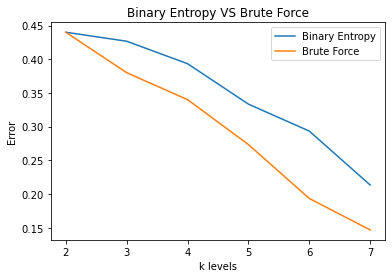

In [312]:
bf_scenarios = [0.44, 0.38, 0.34, 0.2733333333333333, 0.19333333333333333, 0.14666666666666667]
entropy_scenarios = [0.44, 0.4266666666666667, 0.3933333333333333, 0.3333333333333333, 0.29333333333333333, 0.21333333333333335]
scenarios = [2,3,4,5,6,7]
plt.plot(scenarios, entropy_scenarios, label='Binary Entropy')
plt.plot(scenarios, bf_scenarios, label='Brute Force')
plt.legend()
plt.xlabel('k levels') 
plt.ylabel('Error') 
plt.title("Binary Entropy VS Brute Force")
plt.show()

## Run the algorithms and show final results (K=3)

In [313]:
bfAlgorithm = BruteForceAlgorithm(3, vectors_set)
bftree = bfAlgorithm.getTree()
print(f'Minimal errors: {bftree.getError()}')
print(bftree.coordinates)
print()
print_tree(bftree.root)

beAlgorithm = BinaryEntropy(3, vectors_set)
beTree = beAlgorithm.start()
errors_entropy = beAlgorithm.runTree(beTree)
print(f'Minimal errors: {errors_entropy}')
print(beAlgorithm.coordinates)
print()
print_tree(beTree)

Minimal errors: 0.38
[4, 1, 0]

  _4_  
 /   \ 
 1   0 
/ \ / \
0 1 1 0

Minimal errors: 0.4266666666666667
[3, 0, 1]

  _3_  
 /   \ 
 0   1 
/ \ / \
1 0 1 1

